# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.04KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

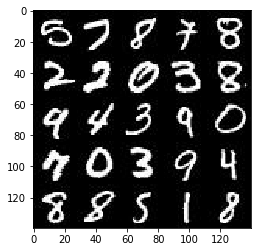

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

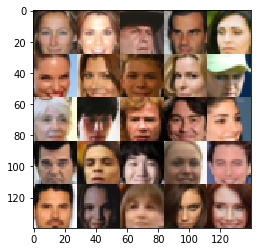

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (
        tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real"),
        tf.placeholder(tf.float32, [None, z_dim], name="input_z"),
        tf.placeholder(tf.float32, name="learning_rate")
    )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding="same")
        x1 = tf.maximum(0.1 * x1, x1)
        # 28x28x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.1 * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.1 * x3, x3)
        # 7x7x256
        
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.5)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [38]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim
        
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Added smoothing based on: https://github.com/soumith/ganhacks/issues/10
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake) * np.random.uniform(0.0, 0.3)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get vars to update:
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    # Optimize them:
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ### Build Model
    losses = []
    step = 0

    _, img_w, img_h, img_c = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_c)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Start saver after initializing variables:
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                ### Train Model
                # Increment step
                step += 1
                
                # Convert range from (-0.5, 0.5) to (-1, 1)
                batch_images *= 2
                
                # Creates a random noise for the whole batch:
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers:
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate
                })
                
                # Track progress
                if step % 20 == 0:
                    d_loss_train = d_loss.eval({
                        input_real: batch_images,
                        input_z: batch_z,
                    })
                    g_loss_train = g_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                    
                    losses.append((d_loss_train, g_loss_train))
                    
                if step % 100 == 0 or step == 1:
                    print("Let's check how well the generator is doing:")
                    show_generator_output(sess, 25, input_z, img_c, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Let's check how well the generator is doing:


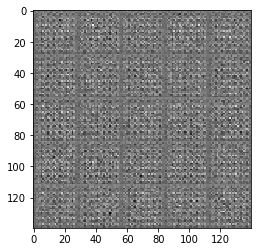

Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 3.8322
Epoch 1/2... Discriminator Loss: 4.4855... Generator Loss: 10.0019
Epoch 1/2... Discriminator Loss: 2.5779... Generator Loss: 0.2165
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.9836... Generator Loss: 0.3552
Let's check how well the generator is doing:


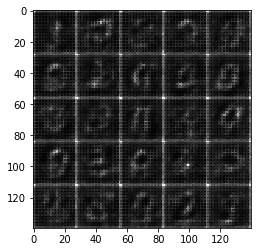

Epoch 1/2... Discriminator Loss: 1.4845... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 1.3807
Epoch 1/2... Discriminator Loss: 1.8215... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 2.0048... Generator Loss: 0.4121
Let's check how well the generator is doing:


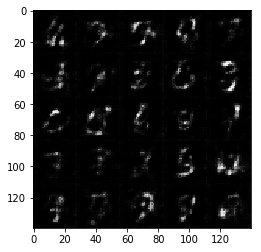

Epoch 1/2... Discriminator Loss: 1.6264... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 2.1650
Epoch 1/2... Discriminator Loss: 2.0676... Generator Loss: 3.9469
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.4388
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.9458
Let's check how well the generator is doing:


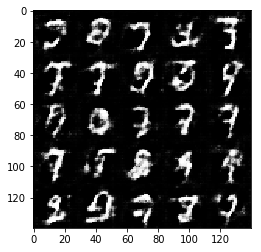

Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 1.6982
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 1.8032... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 2.0432
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.6430
Let's check how well the generator is doing:


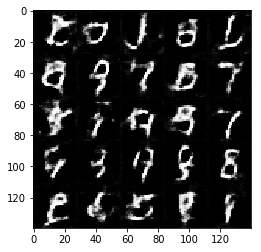

Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.4247
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 2.3714
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.1563
Let's check how well the generator is doing:


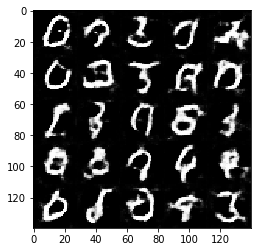

Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 2.6033
Let's check how well the generator is doing:


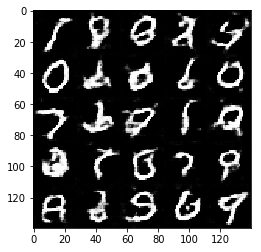

Epoch 1/2... Discriminator Loss: 2.1900... Generator Loss: 3.8368
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 2.0817
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 1.2465
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 1.4210
Let's check how well the generator is doing:


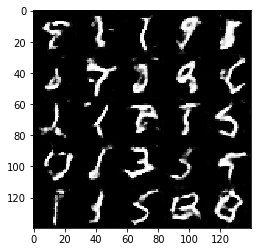

Epoch 1/2... Discriminator Loss: 2.5733... Generator Loss: 3.3100
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 1.6248
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.9548
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 1.1620
Let's check how well the generator is doing:


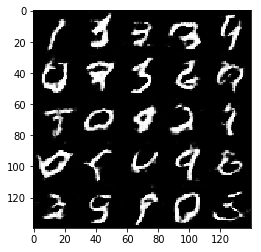

Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 1.4503
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 2.0304
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.8026
Let's check how well the generator is doing:


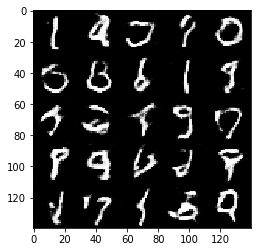

Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 1.8521
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.7146
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.6268
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.7076
Let's check how well the generator is doing:


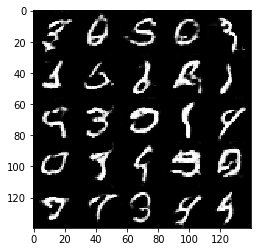

Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.9508
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.1256
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 1.0644
Let's check how well the generator is doing:


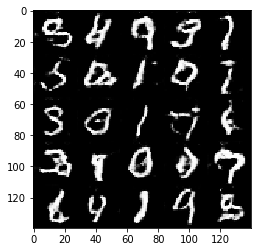

Epoch 1/2... Discriminator Loss: 1.7136... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 1.9418
Epoch 1/2... Discriminator Loss: 1.4939... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 2.3316
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.7322
Let's check how well the generator is doing:


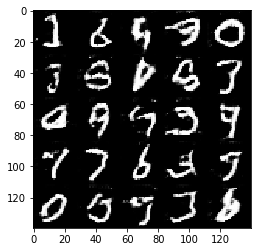

Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 1.7542
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 1.0537
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 2.2594
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.3754
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 2.1496
Let's check how well the generator is doing:


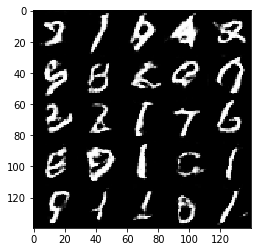

Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 1.7147
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.3410
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 1.4406
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.8374
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.9287
Let's check how well the generator is doing:


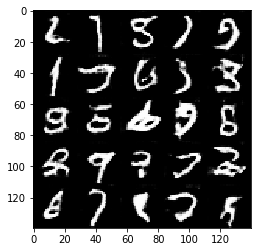

Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 2.0807
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 2.6376
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.5054
Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.7123
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 1.5951
Let's check how well the generator is doing:


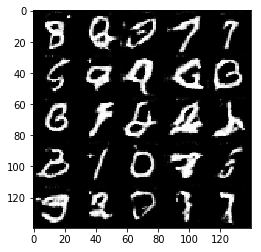

Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 2.0113
Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 1.9392
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 2.3961
Epoch 1/2... Discriminator Loss: 1.7196... Generator Loss: 3.2490
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.2342
Let's check how well the generator is doing:


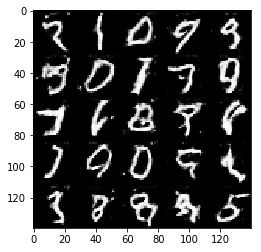

Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.7963
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 2.1562
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 2.2749
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 1.9434
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 1.1291
Let's check how well the generator is doing:


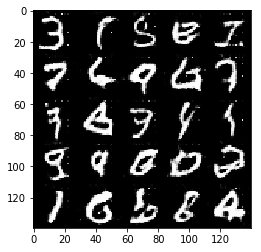

Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.6415
Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 2.2047
Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 1.7147
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 3.4391
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 1.9734
Let's check how well the generator is doing:


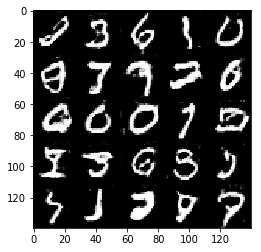

Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 2.6844
Epoch 1/2... Discriminator Loss: 1.2472... Generator Loss: 3.8585
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 0.7703... Generator Loss: 2.8866
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 1.4174
Let's check how well the generator is doing:


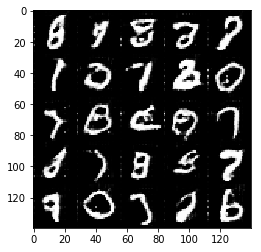

Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 2.3068
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 1.6759
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 1.3202
Let's check how well the generator is doing:


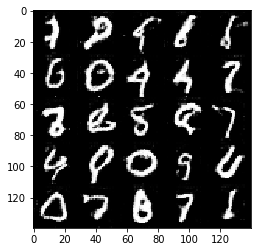

Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 2.2751
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 2.5554
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 2.4913
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 2.8918
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 2.4642
Let's check how well the generator is doing:


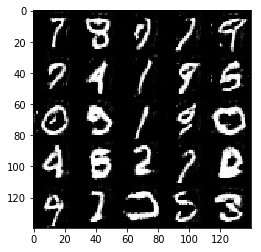

Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.8630
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 2.0756... Generator Loss: 0.4695
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 2.5274
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 2.4049
Let's check how well the generator is doing:


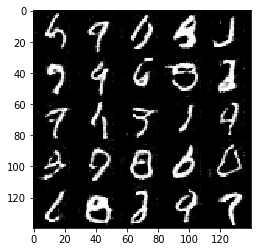

Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 2.0850
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.9930
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 3.3097
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.7831
Let's check how well the generator is doing:


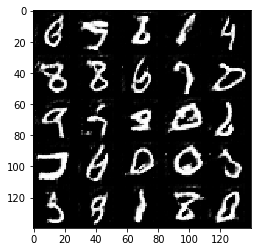

Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 2.2179
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 1.1341
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 1.3692
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.3209
Let's check how well the generator is doing:


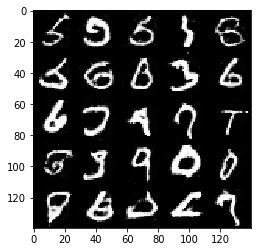

Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 1.6802
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 1.8198
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 2.4396
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 2.0564
Let's check how well the generator is doing:


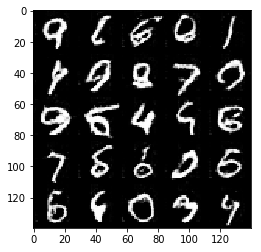

Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 1.6533
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.9364
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 2.0114
Let's check how well the generator is doing:


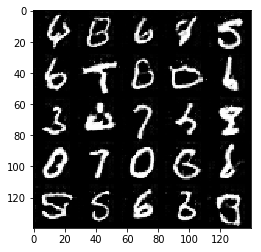

Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.5976
Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 2.4335
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.4146
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 1.1187
Let's check how well the generator is doing:


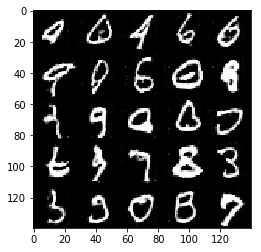

Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 2.2243
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.9636
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 1.7587
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 2.6399
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.4509
Let's check how well the generator is doing:


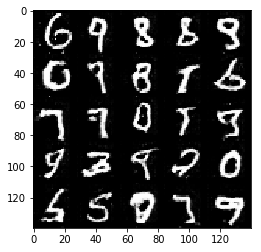

Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 2.2077
Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 1.5530
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.9528
Let's check how well the generator is doing:


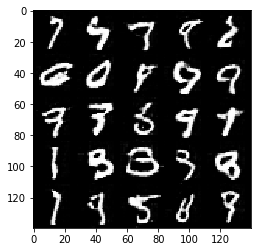

Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 1.9727
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.9425
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 1.3275
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 1.0786
Let's check how well the generator is doing:


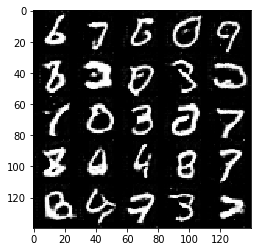

Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.8799
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 3.0063
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 2.3731
Epoch 2/2... Discriminator Loss: 0.8921... Generator Loss: 1.6261
Let's check how well the generator is doing:


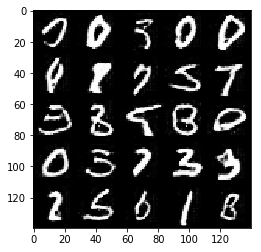

Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 2.0221
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.9881
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 2.5332
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 2.0614
Let's check how well the generator is doing:


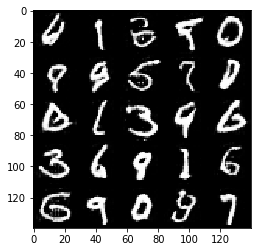

Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.5865
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 1.4872
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 2.4492
Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.9411
Let's check how well the generator is doing:


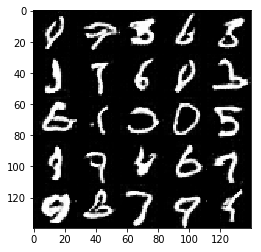

Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 2.0921
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.8915
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 2.6884
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 1.2403
Epoch 2/2... Discriminator Loss: 1.6894... Generator Loss: 0.7742
Let's check how well the generator is doing:


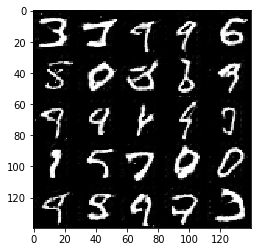

Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.7463
Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 1.7255... Generator Loss: 3.9497
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 1.8385
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.7965
Let's check how well the generator is doing:


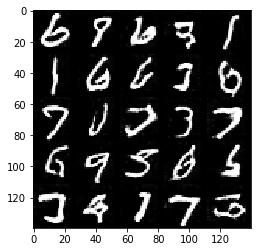

Epoch 2/2... Discriminator Loss: 3.0110... Generator Loss: 4.8881
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 2.1007
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 2.0533
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 2.4195
Let's check how well the generator is doing:


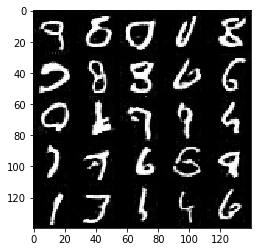

Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 2.1040
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 2.2054
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.8292
Let's check how well the generator is doing:


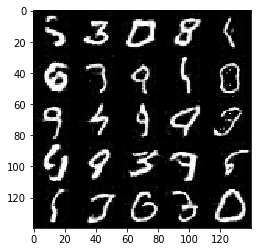

Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.8634
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.2171


In [42]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Let's check how well the generator is doing:


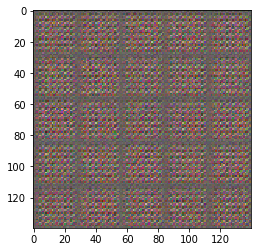

Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 4.8707
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.4413
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 3.2639
Let's check how well the generator is doing:


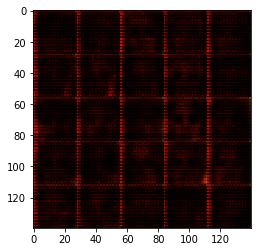

Epoch 1/1... Discriminator Loss: 1.8230... Generator Loss: 2.9494
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 3.1205
Epoch 1/1... Discriminator Loss: 3.2024... Generator Loss: 6.4889
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 3.0395
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 2.6834
Let's check how well the generator is doing:


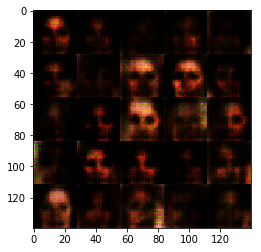

Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 2.7804
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1600
Let's check how well the generator is doing:


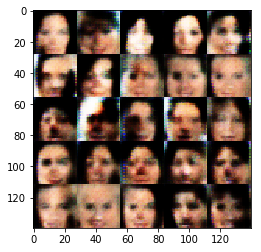

Epoch 1/1... Discriminator Loss: 1.7269... Generator Loss: 4.4861
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 2.1367
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 4.3315
Let's check how well the generator is doing:


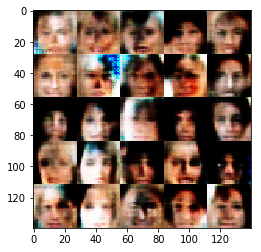

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.4600
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 2.5758
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 2.5973
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.4246
Let's check how well the generator is doing:


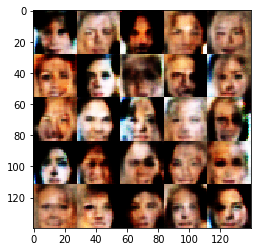

Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 2.5225
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 3.4530
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.3696
Let's check how well the generator is doing:


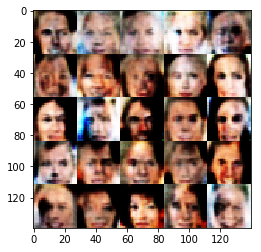

Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 3.1577
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 2.8722
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 3.0267
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 3.7081
Let's check how well the generator is doing:


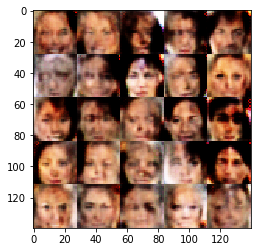

Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 2.3414
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 5.8228
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.7184
Let's check how well the generator is doing:


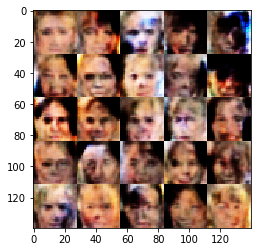

Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 4.0340
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 3.2801
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 4.5482
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.8927
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 2.4006
Let's check how well the generator is doing:


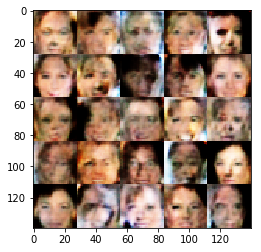

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 2.1335
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 2.6782
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 3.1665
Let's check how well the generator is doing:


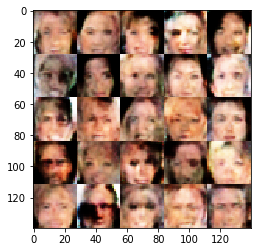

Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 4.1435
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.1989
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 2.6456
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.9653
Let's check how well the generator is doing:


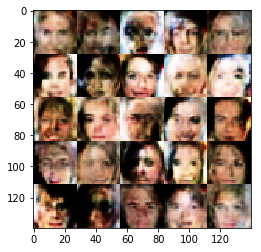

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.6098
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 3.0089
Let's check how well the generator is doing:


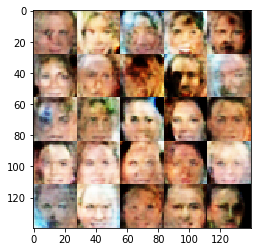

Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 3.0537
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 2.3467
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 2.9194
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.8264
Let's check how well the generator is doing:


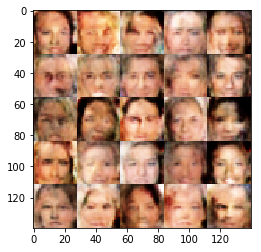

Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 2.8364
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 2.3287
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.9793
Let's check how well the generator is doing:


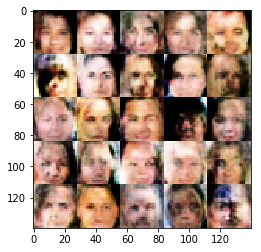

Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 3.4021
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 2.0885
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.2908
Let's check how well the generator is doing:


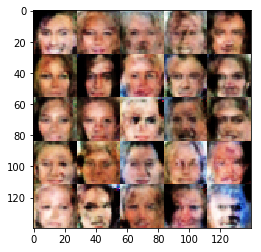

Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 2.1580
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 2.8442
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 2.5597
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 2.5942
Let's check how well the generator is doing:


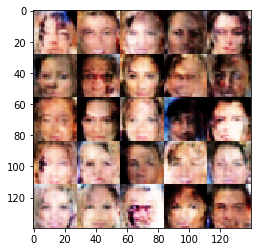

Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 2.7503
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 2.0850
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 5.0238
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 2.3738
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 3.9822
Let's check how well the generator is doing:


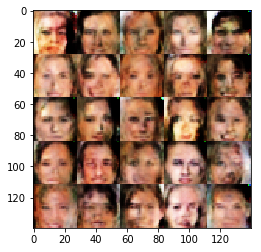

Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 4.6853
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 2.3503
Epoch 1/1... Discriminator Loss: 1.7997... Generator Loss: 4.5442
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 2.4982
Let's check how well the generator is doing:


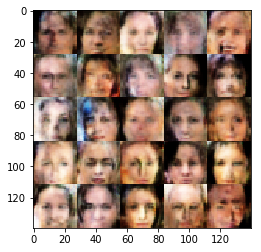

Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 3.2044
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 2.1451
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 3.4654
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.5964
Let's check how well the generator is doing:


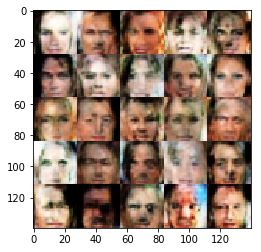

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.8254
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.2354
Let's check how well the generator is doing:


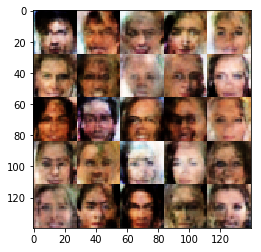

Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 2.0612
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 3.4216
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 2.5050
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 3.3179
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 2.5638
Let's check how well the generator is doing:


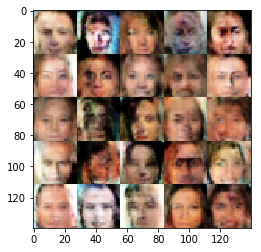

Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 2.0533
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 2.6055
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 4.3949
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 3.5796
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 3.2493
Let's check how well the generator is doing:


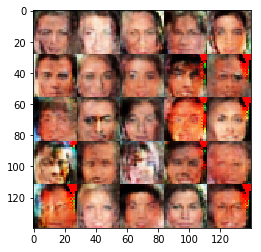

Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 3.8438
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 3.3966
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 2.0683
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.3907
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9740
Let's check how well the generator is doing:


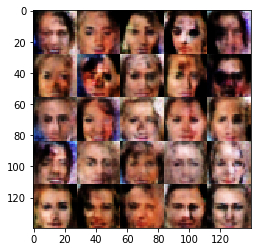

Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 3.4346
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 3.2832
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.6510
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 2.4056
Let's check how well the generator is doing:


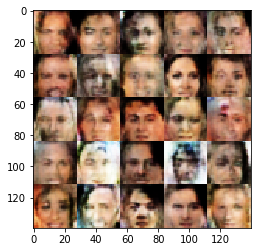

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 3.0142
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.7706
Let's check how well the generator is doing:


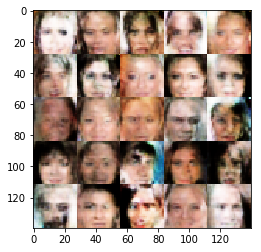

Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 2.5803
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 3.2009
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.5308
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.8913
Let's check how well the generator is doing:


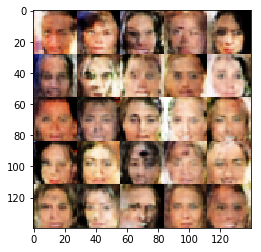

Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.3470
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 2.3102
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 2.9230
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.6118
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.8157
Let's check how well the generator is doing:


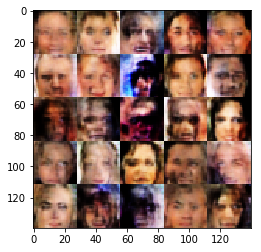

Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 3.4480
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.7199
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 2.0802
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8810
Let's check how well the generator is doing:


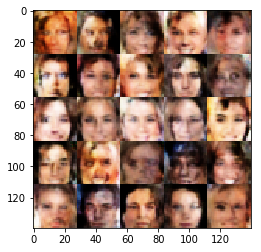

Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 2.5770
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 2.2098
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 3.5513
Let's check how well the generator is doing:


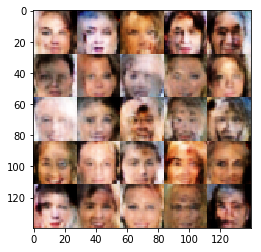

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 2.3842
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7443
Let's check how well the generator is doing:


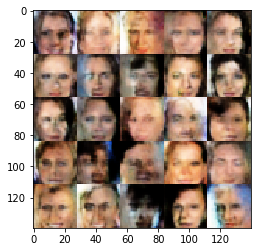

Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 2.2501
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.6909
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.1172
Let's check how well the generator is doing:


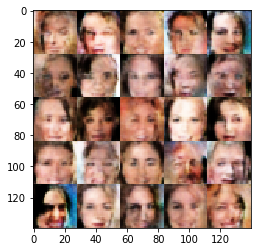

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.8145
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 2.5175... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.6296
Let's check how well the generator is doing:


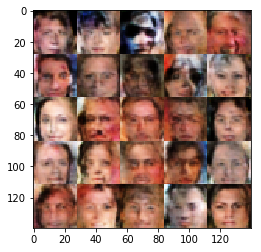

Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.8266
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.8927
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 2.0740
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 2.7590
Let's check how well the generator is doing:


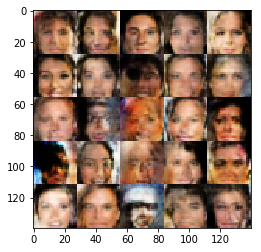

Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 2.2489
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.6047
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.7261
Let's check how well the generator is doing:


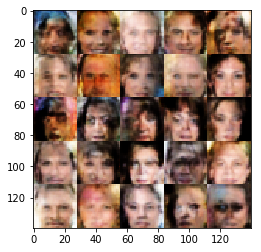

Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 2.1975
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 2.6395
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 2.1842
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 3.7120
Let's check how well the generator is doing:


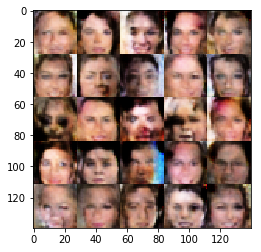

Epoch 1/1... Discriminator Loss: 1.7767... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 2.6182
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 2.2690
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 2.2758
Let's check how well the generator is doing:


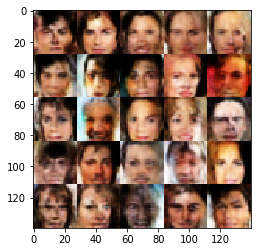

Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 2.1998
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 2.0790
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9408
Let's check how well the generator is doing:


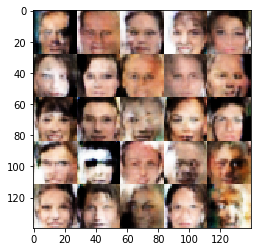

Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 2.8740
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 2.5655
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.2033
Let's check how well the generator is doing:


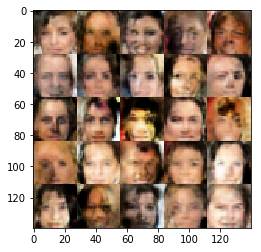

Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 4.0319
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 2.3906
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.5487
Let's check how well the generator is doing:


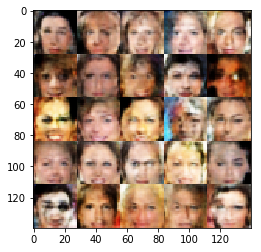

Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 2.9069
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 2.7539
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.8481
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.6676
Let's check how well the generator is doing:


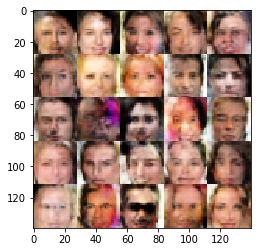

Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 2.7643
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 2.6480
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 2.9219
Let's check how well the generator is doing:


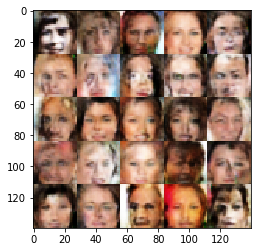

Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 2.4461
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 2.5866
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 2.0002
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.5241
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 2.8189
Let's check how well the generator is doing:


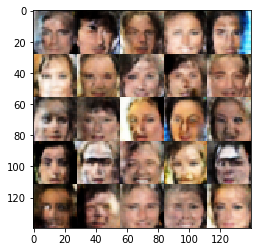

Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.9191
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.5199
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 2.1742
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 3.1230
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 2.7087
Let's check how well the generator is doing:


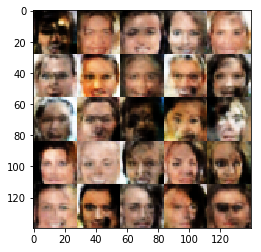

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 2.2771
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.8747
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.9994
Let's check how well the generator is doing:


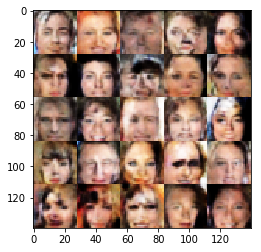

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 2.2537
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.7081
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 2.4494
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9100
Let's check how well the generator is doing:


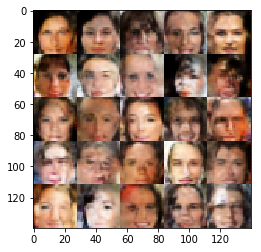

Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 2.4901
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.7197
Let's check how well the generator is doing:


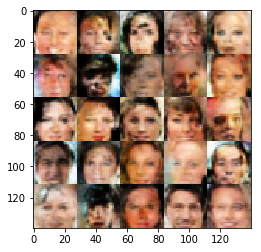

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 2.4543
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 2.0318
Epoch 1/1... Discriminator Loss: 0.7080... Generator Loss: 2.9033
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 3.4534
Let's check how well the generator is doing:


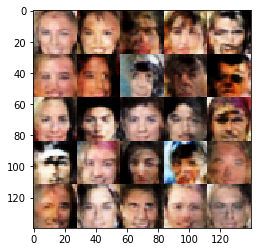

Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 2.5381
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 2.9834... Generator Loss: 3.7325
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.4033
Let's check how well the generator is doing:


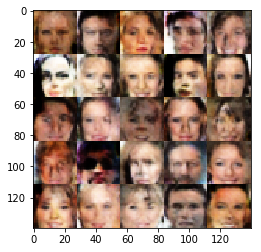

Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 2.6730
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 3.0558
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 3.1917
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 2.7651
Let's check how well the generator is doing:


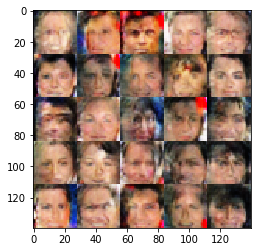

Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 3.1250
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 4.5259
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 4.4318
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 2.9384
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 2.2359
Let's check how well the generator is doing:


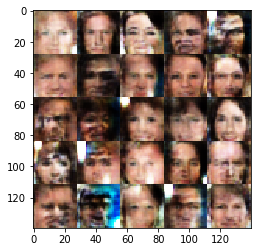

Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 2.6783
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 2.9270
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.2104
Let's check how well the generator is doing:


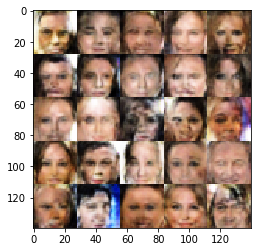

Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 3.2401
Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.7357
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 2.1788
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.5803
Let's check how well the generator is doing:


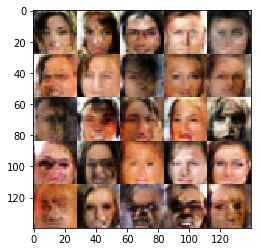

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 3.8095
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 2.4928
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 2.5677
Let's check how well the generator is doing:


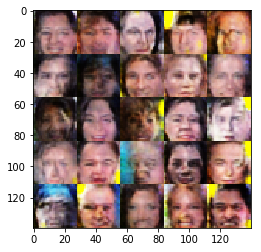

Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 5.1552
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 3.5459
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 3.5794
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.7484
Let's check how well the generator is doing:


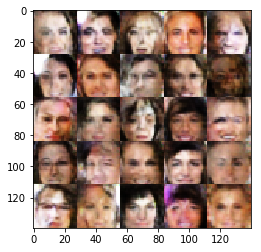

Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 2.7633
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 2.3331
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 3.2415
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 2.5423
Let's check how well the generator is doing:


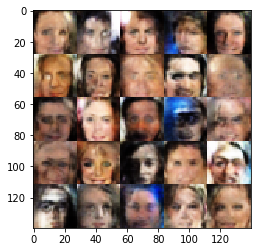

Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 3.7653
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 2.4136
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.1485
Let's check how well the generator is doing:


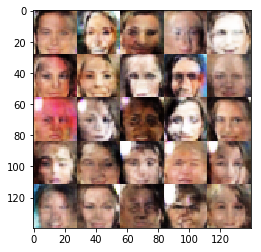

Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 2.8869
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.8339
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 2.8324
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 2.7972
Let's check how well the generator is doing:


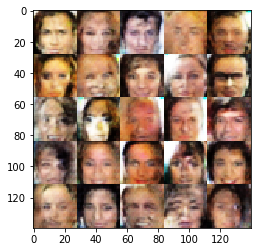

Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 2.1558
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.9351
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 2.3185
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.0366
Let's check how well the generator is doing:


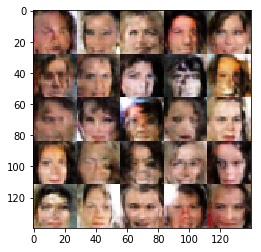

Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 3.5010
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 3.9299
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 3.4800
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.8859
Let's check how well the generator is doing:


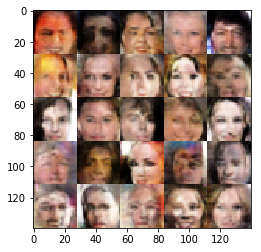

Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 3.7060
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 2.0335
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 2.5907
Let's check how well the generator is doing:


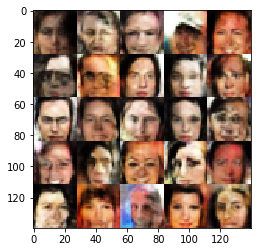

Epoch 1/1... Discriminator Loss: 2.2724... Generator Loss: 0.3240
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 2.4020
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6997
Let's check how well the generator is doing:


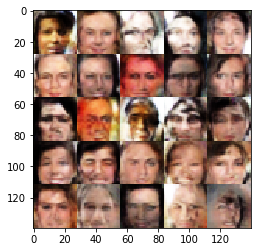

Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 3.5250
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 3.2706
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 2.4111
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.8855
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 2.3970
Let's check how well the generator is doing:


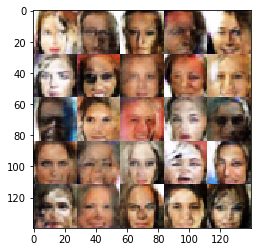

Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 2.2451
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.9999
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 4.4177
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 3.0697
Let's check how well the generator is doing:


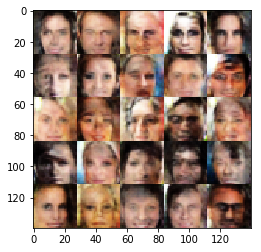

Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 2.4059


In [46]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.